## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
unique_user_id = df['user_id'].unique()
unique_user_id.size

290584

d. The proportion of users converted.

In [5]:
df[df['user_id'].isin(unique_user_id)]['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# get the data from treatment group
df_t = df.query('group=="treatment"')
# get the data from control group
df_c = df.query('group=="control"')
# get the numbers of landing page is not new_page in treatment group and landing page is not old_page in control group
df_t[df_t['landing_page']!='new_page'].shape[0]+df_c[df_c['landing_page']!='old_page'].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Drop the rows which the landing page is not new page in the treatment group
df2 = df.drop(df.query('group=="treatment" & landing_page!="new_page"').index)

In [9]:
# Drop the rows which the landing page is not ol_page in the control group
df2 = df2.drop(df.query('group=="control" & landing_page!="old_page"').index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].unique().size

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(index=df2[df2['user_id'].duplicated()].index, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p_old_obs = df2[df2['group']=='control']['converted'].mean()
p_old_obs

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_new_obs = df2[df2['group']=='treatment']['converted'].mean()
p_new_obs

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2[df2['group']=='treatment'].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

There is no suffucient evidence to say that the new treatment page leads to more conversions.
From question b and c, the convertion rate in "treatment group" is less than that of the "control group".

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer for 1.**  
**$H_0 : p_{new}-p_{old} \leq 0 $**  
**$H_1 : p_{new}-p_{old} \gt 0 $**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2[df2['group']=='treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2[df2['group']=='control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([1,0], size=n_new, replace=True, p=[p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([1,0], size=n_old, replace=True, p=[p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean()-old_page_converted.mean()

-0.0020806694970237766

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
# Define a array to store the difference of page convertion rate
p_diffs = []
# Loop 10000 times for simulate bootstrap sampling
for _ in range(10000):
    # Dataframe to store the simulated convertions of new page 
    new_page_converted = np.random.choice([1,0], size=n_new, replace=True, p=[p_new, 1-p_new])
    # Dataframe to store the simulated convertions of old page
    old_page_converted = np.random.choice([1,0], size=n_old, replace=True, p=[p_old, 1-p_old])
    # Calculte the new page convertion rate
    p_new_sim = new_page_converted.mean()
    # Calculte the old page convertion rate
    p_old_sim = old_page_converted.mean()
    # Calculte the convertion rate difference between new page and old page and store
    p_diffs.append(p_new_sim-p_old_sim)
# Convert to numpy array for further usage
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0,0.5,'Number of case')

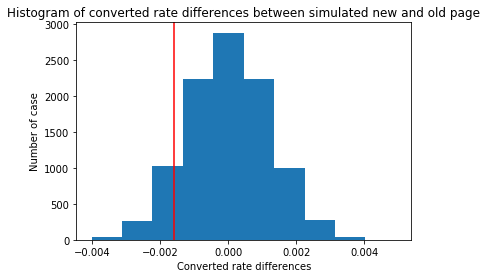

In [27]:
# Find the observed convertion rate of new page
p_new_obs = df2[df2['group']=='treatment']['converted'].mean()
# Find the observed convertion rate of old page
p_old_obs = df2[df2['group']=='control']['converted'].mean()
# Generate histogram of p_diffs
plt.hist(p_diffs)
# Add red line to mark the observed difference
plt.axvline(p_new_obs-p_old_obs,color='r')
# Add title
plt.title('Histogram of converted rate differences between simulated new and old page')
# Add x and y labels
plt.xlabel('Converted rate differences')
plt.ylabel('Number of case')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# Get the portion that p_diffs greater than the actuall observed difference
(p_diffs>(p_new_obs-p_old_obs)).mean()

0.9057

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer for k.**  
The value calculated in part **j.** is called **p-value**. p-value is the probability of observing statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.  
In this case, the p-value means that there is arround 0.90 probability that the conversion rate of old page is greater than that of the new page. But in terms of the threshold of the type I error 5% given in **1.**, the p-value is much greater than the type I error. It means there is no enough evidence to reject the null hypothsis and that is there is no sufficient edvience to say the new page's conversion rate is higher the old one's.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm
#Get the converted number of old page 
convert_old = df2.query('group=="control" & converted==1').shape[0]
#Get the converted number of new page
convert_new = df2.query('group=="treatment" & converted==1').shape[0]
# Get the number of control group
n_old = df2[df2['group']=='control'].shape[0]
# Get the number of treatment group
n_new = df2[df2['group']=='treatment'].shape[0]
# Show above data
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
# Use built-in function to calculate the z-score and p-value based on above data
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
# Show result
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer for n.**  
A z-score indicates how many standard deviations an element is from the mean. In this case, the z-score means that the observed difference have 1.3109 times standard deviation below the mean which is 0. The p-value suggests that there has 0.9051 probability that the new page has a higher conversion rate than the old page.  
They are match the findings in part j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer for a.**  
Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
# Get dummy data from the group, and only keep the treatment column
df_page = pd.get_dummies(df2['group'])['treatment']
# Join the dummy column with the prevoius dataframe
df2 = df2.join(df_page)
# Rename the treatment column as ab_page
df2.rename(columns={'treatment':'ab_page'},inplace=True)
# Add intercept
df2['intercept']=1
# Check the dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
# Create logistic model to predict the page convertion by ab_page
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
# Fit the model
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
# Show the summary of the fit result 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        08:32:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer for e.**  
The p-value from the regression is 0.190. The p-value here is different from that in **Part II** is because the null hypothsis are different. The null hypothsis in this regression model is that the coefficient between the *converted* and *ab_page* columns is equal to zero. While the null hypothsis in **Part II** is the convertion rate of the treatment group is less than or equal to the convertion rate of the control group. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer for f.**  
Including other factors can give us different views to predict the response. There are several things can be taken into conderation:  
- The users' infomation. Does the users is exsiting users or new users that never visit this website before? This may have bias on existing users like the aversion changes and novelty effect. 
- The users geographic distribution (e.g. countries and states).
- The week information from the timestamp (e.g. Mon, Tue...) may also have influence on the prediction.

Disadvantages:  
As multiple factors are added, there are more combinations of factors need to be considered to create regression models(high order terms will be introduced such as interaction, quadratic and cubic). It will be difficult and complex to interpret the result if multiple linear regression models are used.

#### Below, the day of week which can be extract from the timestamp column is added to predict the convertion rate

In [34]:
# Copy df2 to a new dataframe so that the df2 will not be impacted
df2_week = df2.copy()
# Convert the string type of timestamp column to datetime type
df2_week['timestamp'] = pd.to_datetime(df2_week['timestamp'])
# Add new column day_of_week to store the day of week for the click event
df2_week['day_of_week']=df2_week['timestamp'].dt.dayofweek

In [35]:
# Create the Logistic model with the day of week column
log_mod = sm.Logit(df2_week['converted'], df2_week[['intercept','day_of_week']])
# Fit the model
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


In [36]:
# Show the result summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               5.614e-06
Time:                        08:32:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2744
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9873      0.010   -199.805      0.000      -2.007      -1.968
day_of_week    -0.0031      0.003     -1.093      0.274      -0.009       0.002
===============================================================================
"""

**Conclusion of considering day of week as the fator:**   
Based on the p-value of the above result, it shows that the day of week also have no significant impact on the covertion rate.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# Read country dataset and create a new datafame
countries_df = pd.read_csv('./countries.csv')
# Set user_id as the index and join with previous dataframe
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
# Check the new dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
# Show the unique countries
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
# Generate dataframe for countries
df_country = pd.get_dummies(df_new['country'])
# Join new dataframe with the countries dataframe
df_new = df_new.join(df_country, how='inner')
# Drop 'CA' column to keep all columns are independ
df_new.drop(columns=['CA'], inplace=True)
# Check the new dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [40]:
# Create regression model to predict the conversion rate based on country
# Note that the model will use CA as the base
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','UK','US']])
# Fit the model
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [41]:
# Get summary of the fit result
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        08:32:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**Answer for g.**  
Based on the above summary, the counrty factor do have impact on the conversion rate, but the impact is not statistic significant(if the alpha is 5%). 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
# create new columns to store the interaction information of page type and country
# interact column between page and US
df_new['page_US'] = df_new['ab_page']*df_new['US']
# interact column between page and UK
df_new['page_UK'] = df_new['ab_page']*df_new['UK']
# interact column between page and CA
df_new['page_CA'] = df_new['ab_page']*(1-(df_new['UK']+df_new['US']))

In [43]:
# Check the dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,page_US,page_UK,page_CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0,1,0


In [44]:
# Create the model to predict the convertion rate by interations of new/old page and countries
log_mod = sm.Logit(df_new['converted'],df_new[['intercept','page_US','page_UK','page_CA']])
# Fit model
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [45]:
# Show the result summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               3.351e-05
Time:                        08:32:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
page_US       -0.0183      0.013     -1.449      0.147      -0.043       0.006
page_UK        0.0074      0.018      0.410      0.682      -0.028       0.043
page_CA       -0.0827      0.038     -2.176      0.030      -0.157      -0.008
==============================================================================
"""

**Anwser for h.**  
From the p-values of the three combinations (page_US, page_UK and page_CA), the interaction between page and Canada has a statistic significant. The other two interations don't have much relationship with the convertion rate.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

## Reference

[1] https://stattrek.com/statistics/dictionary.aspx?definition=z_score